# Unit Testing Optimisation

## Importing the Packages

In [162]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [163]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [164]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [165]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Obtaining Training Data

In [166]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

### Importing Spike Trains and Finger Movement

In [167]:
data = pd.read_hdf('./Data/finger_posdata.h5')
k = 5000
num_filt = 1
xdata = data.spikes.to_numpy()[:k, :num_filt]
print(xdata.shape)
data.index = data.index - data.index[0]
ytime = (data.index / np.timedelta64(1, 's')).to_numpy()[:k]
ycoord = data.finger_pos.y.to_numpy()[:k]
xcoord = data.finger_pos.x.to_numpy()[:k]
k, num_filt = np.shape(xdata)
k -= 1
ydata = ycoord.reshape(k + 1, 1)
xdata = xdata.reshape(num_filt, k + 1, 1)
data.spikes

(5000, 1)


channel,201,203,204,301,401,601,701,802,901,1001,...,9001,9103,9201,9203,9301,9403,9501,9502,9601,9602
clock_time,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.002000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.003000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:00:00.004000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:02:39.908000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:02:39.909000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 days 00:02:39.910000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Setting up Filter Sizes

In [168]:
subkeyf = subkeys[-2]

# Time bin size
time_bin = ytime[1] - ytime[0]

# Filter horizon
f_maxt = 1.0

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1).reshape((n + 1, 1))

In [169]:
xpad = np.hstack((xdata, np.zeros((num_filt, n, 1))))
x_fft = np.fft.rfft(xpad, axis=1)
print(x_fft.shape)
print(xdata.shape)
print(ydata.shape)
print(ftime.shape)

(1, 3001, 1)
(1, 5000, 1)
(5000, 1)
(1001, 1)


## Variational Inference

### ELBO

#### Kl Divergence Term

In [170]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return  0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

In [171]:
test_number_f = 10
test_num_base = 10
test_m = int(10)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = 5.0 - random.normal(test_subkeys[0], (num_filt, 1))
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_v_m = np.ones(test_m * num_filt).reshape((num_filt, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (num_filt, 1, 1)) + random.normal(test_subkeys[1], (num_filt, test_m, test_m))
test_trise = 0.02 * np.ones((num_filt, 1))
test_tdecay = 0.03 * np.ones((num_filt, 1))
test_lag = 0.01 * np.ones((num_filt, 1))

In [172]:
print(KL_Term(test_l_mm, test_v_m, test_m).shape)

()


#### Expected Log-Likelihood

In [173]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [174]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [175]:
@partial(jit, static_argnums = range(9,15))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F, Num_Base,
                  M, Number_Filt, N, K, Y_Test, X_Fft, F_Time, Subkeys):

  Sigma_f_d = Sigma_f[:, :, None]
  Ell_f_d = Ell[:, :, None]
  TRise_d = TRise[:, :, None]
  TauDiff_d = TauDiff[:, :, None]

  Thetas = random.normal(Subkeys[0], (Number_F, Number_Filt, 1, Num_Base)) * (1.0 / Ell_f_d)

  Taus = random.uniform(Subkeys[1], (Number_F, Number_Filt, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Number_Filt, Num_Base, 1))

  Constant = (Sigma_f_d * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f_d, Ell_f_d)
  Knm = Squared_exp(F_Time, ZT, Sigma_f_d, Ell_f_d)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))
  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Number_Filt, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise_d, TauDiff_d, Lag)

  F_Samples = jnp.dstack((F_Samples, jnp.zeros((Number_F, Number_Filt, K, 1))))
  
  F_Fft = jnp.fft.rfft(F_Samples, axis = -2)

  Filter_Out = jnp.fft.irfft(F_Fft * X_Fft, N + K + 1, axis = -2)[:, :, : K + 1]

  Pred = jnp.sum(Filter_Out, axis = 1)
  
  Likelihoods = - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Y_Test - Pred)**2, axis = 1)/(Sigma_n ** 2))
  
  return jnp.mean(Likelihoods)

In [176]:
test_number_f = 15
test_num_base = 300
test_m = int(10)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = np.ones((num_filt, 1))# np.arange(num_filt).reshape(1, num_filt, 1, 1)
test_ell_f = np.linspace(0.01, 0.5, num_filt).reshape(num_filt, 1)
test_sigma_n = 0.5
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_v_m = np.ones(test_m * num_filt).reshape((num_filt, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (num_filt, 1, 1)) + random.normal(test_subkeys[1], (num_filt, test_m, test_m))
test_trise = np.linspace(0.01, 1.0, num_filt).reshape((num_filt, 1))
test_tdiff = np.linspace(0.01, 0.5, num_filt).reshape((num_filt, 1))
test_lag = np.linspace(0.01, 0.5, num_filt).reshape((num_filt, 1))[:, :, None]

In [177]:
samps = Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, test_num_base, test_m, num_filt, n, k, ydata, x_fft, ftime, test_subkeys)

In [178]:
print(samps)

-38764960.24666469


#### ELBO

In [179]:
Diag = jit(vmap(jnp.diag, in_axes=[0,]))

In [180]:
@partial(jit, static_argnums = range(10, 16))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F, Num_Base,
         M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys):
         
  Lag = Lag ** 2.0

  Lag_d = Lag[:, :, None]
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag_d) + Lag_d

  D = Diag(jnp.exp(L_Diag))

  L_Matrix = D.at[:, Indices[0], Indices[1]].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag_d, Number_F, Num_Base,
                  M, Number_Filt, N, K, Y_Test, X_Fft, F_Time, Subkeys)
                  
  return (KL-Exp)/(Number_Filt + K + 1)

In [181]:
test_number_f = 15
test_num_base = 300
test_m = int(10)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = np.ones((num_filt, 1))# np.arange(num_filt).reshape(1, num_filt, 1, 1)
test_ell_f = np.linspace(0.01, 0.5, num_filt).reshape(num_filt, 1)
test_sigma_n = 0.5
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = np.ones(test_m * num_filt).reshape((num_filt, test_m, 1))
test_l_diag = np.ones(test_m * num_filt).reshape((num_filt, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_filt, 1))
test_trise = np.linspace(0.01, 1.0, num_filt).reshape((num_filt, 1))
test_tdiff = np.linspace(0.01, 0.5, num_filt).reshape((num_filt, 1))
test_lag = np.linspace(0.01, 0.5, num_filt).reshape((num_filt, 1))
test_diagMat = Diag(test_l_diag)
test_indices = np.tril_indices(test_m, -1)

In [182]:
test_d = Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdecay, test_lag, test_number_f, test_num_base, test_m, num_filt, n, k, test_indices, ydata, x_fft, ftime, test_subkeys)

In [183]:
print(test_d)

7751.290421089094


In [184]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 16))

### Optimiser

#### Sub-function Definitions

In [185]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [186]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [187]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [188]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [189]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [190]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [191]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [192]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [193]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [194]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [195]:
@partial(jit, static_argnums = range(12,18))
def _CUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [196]:
@partial(jit, static_argnums = range(12,18))
def _MUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [197]:
@partial(jit, static_argnums = range(12,18))
def _FUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Base, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Base, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [198]:
@partial(jit, static_argnums = range(5, 11))
def AdamOpt(Init_Params, X_Fft, Indices, Y_Test, F_Time, M, Number_Filt, N, K, Num_Fs, Num_Bases,              
                        Coarse_Schedule = jnp.asarray([400, 400, 700]), Mid_Schedule = jnp.asarray([16500]),
                        Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(20000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(0)
  Key, *Subkeys = random.split(Key, 5)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, (Params, Subkeys, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [199]:
print(test_sigma_f.shape)
print(test_ell_f.shape)
print(test_sigma_n)
print(test_trise.shape)
print(test_tdiff.shape)
print(test_lag.shape)
print(test_z_m.shape)
print(test_v_m.shape)
print(test_l_diag.shape)
print(test_l_odiag.shape)
print(ftime.shape)
print(xdata.shape)
print(ydata.shape)

(1, 1)
(1, 1)
0.5
(1, 1)
(1, 1)
(1, 1)
(1, 10, 1)
(1, 10, 1)
(1, 10)
(1, 45)
(1001, 1)
(1, 5000, 1)
(5000, 1)


In [200]:
key = random.PRNGKey(4)
key, *subkeys = random.split(key, 9)

# Initialising the parameters

# Generative parameters
isigma_f = 5.0 * (jnp.ones((num_filt, 1)) - 0.1 * random.normal(subkeys[0], (num_filt, 1)))
iell = 0.002 * (jnp.ones((num_filt, 1)) - 0.1 * random.normal(subkeys[1], (num_filt, 1)))
isigma_n = 0.000005

itrise = np.sqrt(0.05) * (jnp.ones((num_filt, 1)) - 0.1 * random.normal(subkeys[2], (num_filt, 1)))
itaudiff = np.sqrt(0.01) * (jnp.ones((num_filt, 1)) - 0.1 * random.normal(subkeys[3], (num_filt, 1)))
ilag = np.sqrt(0.01) * (jnp.ones((num_filt, 1)) - 0.1 * random.normal(subkeys[4], (num_filt, 1)))

# Variational parameters
num_ind = 5
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape(num_ind, 1), (num_filt, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
iv_vector = 0.01 * random.normal(subkeys[5], (num_filt, num_ind,1))
il_diag = 0.01 * random.normal(subkeys[6], (num_filt, num_ind))
il_odiag = 0.1 * random.normal(subkeys[7], (num_filt, int((num_ind ** 2 - num_ind) / 2)))
num_f = 20
num_b = 100
indices = jnp.tril_indices(num_ind, -1)

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, *opt_subkey = random.split(opt_key, 5)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, num_filt, n, k, indices, ydata, x_fft, ftime)
print(iz_final.shape)
print(isigma_f.shape)

(1, 5, 1)
(1, 1)


In [201]:
print(Grad_Bound(*params, num_f, num_b, num_ind, num_filt, n, k, indices, ydata, x_fft, ftime, opt_subkey))

(DeviceArray(7.77292478e+13, dtype=float64), (DeviceArray([[7.39706334e+10]], dtype=float64), DeviceArray([[-3.91840783e+14]], dtype=float64), DeviceArray(-3.10916991e+19, dtype=float64, weak_type=True), DeviceArray([[[-1.35175995e-04],
              [ 4.86820188e+12],
              [ 3.66520348e+10],
              [ 8.92807206e+08],
              [ 1.79430509e-10]]], dtype=float64), DeviceArray([[[-1.01780519e+10],
              [-3.55971819e+10],
              [-1.02704310e+09],
              [-1.98373829e+07],
              [-2.14869689e+05]]], dtype=float64), DeviceArray([[ 1.32787249e+09, -2.38777075e+09,  2.86529179e+08,
               3.10720534e+06, -6.25180242e+04]], dtype=float64), DeviceArray([[ 4.47103671e+09,  1.28027177e+08, -7.51447987e+07,
               2.50283154e+06, -1.44678557e+06,  5.50721097e+06,
               2.75254050e+04, -1.59160503e+04,  5.92026689e+04,
               3.31274934e+04]], dtype=float64), DeviceArray([[1.27806265e+12]], dtype=float64), DeviceA

In [202]:
fparams, elbo_history = AdamOpt(params, x_fft, indices, ydata, ftime, num_ind, num_filt, n, k, num_f, num_b)

In [203]:
print(Neg_ELBO(*params, num_f, num_b, *consparams, opt_subkey))

77729247803189.12


In [204]:
print(Neg_ELBO(*fparams, num_f, num_b, *consparams, opt_subkey))

6.060957787448221


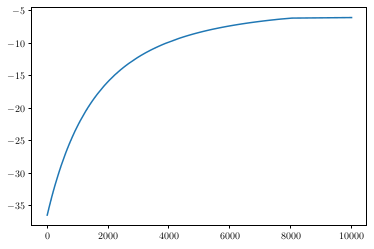

In [205]:
plt.plot(elbo_history[10000:])
#plt.ylim([1.0, 1.6])

In [206]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [207]:
ilag = ilag ** 2

ilag_d = ilag[:, :, None]

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag_d) + ilag_d

idz = np.asarray(Diag(np.exp(il_diag)))
il_matrix = idz.copy()
il_matrix[:, indices[0], indices[1]] = il_odiag


flag = flag ** 2

flag_d = flag[:, :, None] 

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag_d) + flag_d

fd = np.asarray(Diag(np.exp(fl_diag)))
fl_matrix = fd.copy()
fl_matrix[:, indices[0], indices[1]] = fl_odiag

In [208]:
print(fsigma_f)

[[6.76938144]]


In [209]:
print(fell)

[[0.27359457]]


In [210]:
print(fsigma_n)

10.901980641391496


In [211]:
print(ftrise)

[[-0.01427665]]


In [212]:
print(ftaudiff)

[[1.86254807]]


In [213]:
print(flag)

[[1.45411853e-09]]


## Variational Predictions

In [214]:
fpred_points = ftime.copy()

In [215]:
isigma_f = isigma_f.reshape(num_filt, 1, 1)
iell = iell.reshape(num_filt, 1, 1)
itrise = itrise.reshape(num_filt, 1, 1)
itaudiff = itaudiff.reshape(num_filt, 1, 1)

fsigma_f = fsigma_f.reshape(num_filt, 1, 1)
fell = fell.reshape(num_filt, 1, 1)
ftrise = ftrise.reshape(num_filt, 1, 1)
ftaudiff = ftaudiff.reshape(num_filt, 1, 1)

In [216]:
print(iell.shape)
print(iz_vector.shape)
print(itrise.shape)

(1, 1, 1)
(1, 5, 1)
(1, 1, 1)


In [218]:
ikmm = Squared_exp(iz_vector, iz_vector.T, isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vector, fpred_points.T, isigma_f, iell)
ibzast = np.zeros((num_filt, num_ind, n + 1))
ibzastT = ibzast.transpose(0, 2, 1)
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ipredenv = AlpEnvelope(fpred_points, itrise, itaudiff, ilag)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vector)

ikastast = Squared_exp(fpred_points, fpred_points.T, isigma_f, iell)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrix @ il_matrix.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [219]:
fkmm = Squared_exp(fz_vector, fz_vector.T, fsigma_f, fell)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vector, fpred_points.T, fsigma_f, fell)
fbzast = np.zeros((num_filt, num_ind, n + 1))
fbzastT = fbzast.transpose(0, 2, 1)
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fpredenv = AlpEnvelope(fpred_points, ftrise, ftaudiff, flag)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vector)

fkastast = Squared_exp(fpred_points, fpred_points.T, fsigma_f, fell)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrix @ fl_matrix.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [220]:
print(fmeanpred[0].shape)
print(xdata[0].shape)

(1001, 1)
(5000, 1)


In [222]:
prediction = np.zeros((k + 1,))
for i in range(num_filt):
  prediction += np.convolve(xdata[i].flatten(), fmeanpred[i].flatten())[:k + 1]

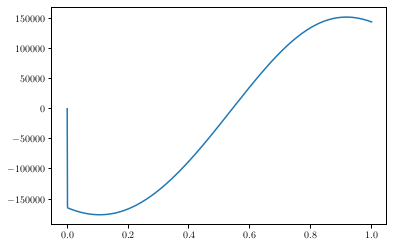

In [225]:
plt.plot(ftime, fmeanpred[0])

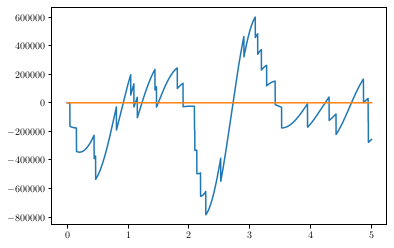

In [224]:
plt.plot(ytime, prediction)
plt.plot(ytime.flatten(), ydata)